## Modelo de Identificación: Trazas en Canal de Drenaje de Molinos Con Dia de Zafra

In [1]:
# Importacion de Librerias
import os
os.environ["OMP_NUM_THREADS"] = '2'

import numpy as np
import pandas as pd
import seaborn as sns
import funciones   # Importacion de funciones personalizadas
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix,  f1_score, precision_score, recall_score, silhouette_score

#### Carga del Dataset (Variables del Sistema de Control)

Se utilizan los datos de Laboratorio sobre trazas en el canal efluente indicado. Dado que la muestra corresponde a un instante determinado, para poder correlacionar valores en el sistema de control se toma el *valor promedio de la variable del sistema en el período entre 5 minutos antes de la muestra y 5 minutos después de la muestra*, de esta manera se tiene un valor más representativo de la distribución de las variables al momento de medir la traza.

In [2]:
# Carga del Dataset
df_raw = pd.read_csv('Trazas_Canal_Molinos.csv',sep=";" , encoding='latin1') # Lectura del archivo csv
df_raw

,Id,Fecha,Dia Zafra,Hora,Punto de Muestreo,Estampa de Tiempo,Inicio,Fin,Traza (mg/L),FT553705 Flujo agua asepsia Patio T-A (Gpm) AVG,...,LT580704 Nivel Vaso E1 (%) AVG,LT580704 Nivel Vaso E1 (%) STD,LT580604 Nivel Vaso E2 (%) AVG,LT580604 Nivel Vaso E2 (%) STD,LT581704 Nivel Vaso E3 (%) AVG,LT581704 Nivel Vaso E3 (%) STD,LT581603 Nivel Vaso E4 (%) AVG,LT581603 Nivel Vaso E4 (%) STD,CT55101 Conductividad Canal Molinos (uS) AVG,CT55101 Conductividad Canal Molinos (uS) STD
0,1,10/11/2023,1,22:00,CANAL DRENAJE MOLINOS,10/11/2023 22:00,10/11/2023 21:55,10/11/2023 22:05,688,0.0,...,69.39,12.04,60.57,2.83,38.85,3.68,70.73,5.96,0.00,0.00
1,2,11/11/2023,1,01:35,CANAL DRENAJE MOLINOS,11/11/2023 01:35,11/11/2023 01:30,11/11/2023 01:40,3642,0.0,...,10.80,0.06,57.79,5.08,0.08,0.07,46.09,8.62,0.00,0.00
2,3,11/11/2023,1,04:58,CANAL DRENAJE MOLINOS,11/11/2023 04:58,11/11/2023 04:53,11/11/2023 05:03,1915,0.0,...,25.16,15.55,24.94,0.28,63.85,0.15,49.55,3.59,0.00,0.00
3,4,11/11/2023,1,09:11,CANAL DRENAJE MOLINOS,11/11/2023 09:11,11/11/2023 09:06,11/11/2023 09:16,2027,0.0,...,77.22,7.10,0.00,0.00,0.20,0.08,38.68,46.17,0.00,0.00
4,5,11/11/2023,1,13:42,CANAL DRENAJE MOLINOS,11/11/2023 13:42,11/11/2023 13:37,11/11/2023 13:47,4706,0.0,...,45.66,1.39,0.00,0.00,21.97,6.61,31.56,6.72,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,589,18/02/2024,99,05:20,CANAL DRENAJE MOLINOS,18/02/2024 05:20,18/02/2024 05:15,18/02/2024 05:25,1389,0.0,...,66.25,12.62,45.49,4.45,62.09,10.31,59.56,11.00,366.49,38.71
589,590,18/02/2024,99,09:22,CANAL DRENAJE MOLINOS,18/02/2024 09:22,18/02/2024 09:17,18/02/2024 09:27,4881,0.0,...,2.19,0.05,21.84,3.60,0.00,0.01,4.85,2.26,110.01,79.88
590,591,18/02/2024,99,13:20,CANAL DRENAJE MOLINOS,18/02/2024 13:20,18/02/2024 13:15,18/02/2024 13:25,4305,0.0,...,15.29,7.96,43.78,2.68,39.43,6.43,100.00,0.00,703.05,246.15
591,592,18/02/2024,99,16:50,CANAL DRENAJE MOLINOS,18/02/2024 16:50,18/02/2024 16:45,18/02/2024 16:55,2328,0.0,...,58.42,18.32,44.55,0.80,49.72,4.58,97.87,0.51,91.80,9.74


#### Revision de de conjunto de datos

In [3]:
# Remplazo de valores con error
# Se identifican 2 tipos de errores en la extracción del sistema de control:  
df_raw.replace("[-11059] No Good Data For Calculation",np.nan,inplace = True) # Se remplazan por nan los valores con error tipo 1
df_raw.replace("Tag not found",np.nan,inplace = True) # Se remplaza por nan los valores con error tipo 2
df_raw

,Id,Fecha,Dia Zafra,Hora,Punto de Muestreo,Estampa de Tiempo,Inicio,Fin,Traza (mg/L),FT553705 Flujo agua asepsia Patio T-A (Gpm) AVG,...,LT580704 Nivel Vaso E1 (%) AVG,LT580704 Nivel Vaso E1 (%) STD,LT580604 Nivel Vaso E2 (%) AVG,LT580604 Nivel Vaso E2 (%) STD,LT581704 Nivel Vaso E3 (%) AVG,LT581704 Nivel Vaso E3 (%) STD,LT581603 Nivel Vaso E4 (%) AVG,LT581603 Nivel Vaso E4 (%) STD,CT55101 Conductividad Canal Molinos (uS) AVG,CT55101 Conductividad Canal Molinos (uS) STD
0,1,10/11/2023,1,22:00,CANAL DRENAJE MOLINOS,10/11/2023 22:00,10/11/2023 21:55,10/11/2023 22:05,688,0.0,...,69.39,12.04,60.57,2.83,38.85,3.68,70.73,5.96,0.00,0.00
1,2,11/11/2023,1,01:35,CANAL DRENAJE MOLINOS,11/11/2023 01:35,11/11/2023 01:30,11/11/2023 01:40,3642,0.0,...,10.80,0.06,57.79,5.08,0.08,0.07,46.09,8.62,0.00,0.00
2,3,11/11/2023,1,04:58,CANAL DRENAJE MOLINOS,11/11/2023 04:58,11/11/2023 04:53,11/11/2023 05:03,1915,0.0,...,25.16,15.55,24.94,0.28,63.85,0.15,49.55,3.59,0.00,0.00
3,4,11/11/2023,1,09:11,CANAL DRENAJE MOLINOS,11/11/2023 09:11,11/11/2023 09:06,11/11/2023 09:16,2027,0.0,...,77.22,7.10,0.00,0.00,0.20,0.08,38.68,46.17,0.00,0.00
4,5,11/11/2023,1,13:42,CANAL DRENAJE MOLINOS,11/11/2023 13:42,11/11/2023 13:37,11/11/2023 13:47,4706,0.0,...,45.66,1.39,0.00,0.00,21.97,6.61,31.56,6.72,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,589,18/02/2024,99,05:20,CANAL DRENAJE MOLINOS,18/02/2024 05:20,18/02/2024 05:15,18/02/2024 05:25,1389,0.0,...,66.25,12.62,45.49,4.45,62.09,10.31,59.56,11.00,366.49,38.71
589,590,18/02/2024,99,09:22,CANAL DRENAJE MOLINOS,18/02/2024 09:22,18/02/2024 09:17,18/02/2024 09:27,4881,0.0,...,2.19,0.05,21.84,3.60,0.00,0.01,4.85,2.26,110.01,79.88
590,591,18/02/2024,99,13:20,CANAL DRENAJE MOLINOS,18/02/2024 13:20,18/02/2024 13:15,18/02/2024 13:25,4305,0.0,...,15.29,7.96,43.78,2.68,39.43,6.43,100.00,0.00,703.05,246.15
591,592,18/02/2024,99,16:50,CANAL DRENAJE MOLINOS,18/02/2024 16:50,18/02/2024 16:45,18/02/2024 16:55,2328,0.0,...,58.42,18.32,44.55,0.80,49.72,4.58,97.87,0.51,91.80,9.74


In [4]:
# Revision de valores nan, identificacion de columnas y calculo de % de valores nan
print("\nPorcentaje de Valores \033[1mnan\033[0m por columna:")
(df_raw.isna().sum()[df_raw.isna().sum() > 0]/len(df_raw))*100  # Se muestran las columnas que contienen valores nan   


Porcentaje de Valores nan por columna:


LT55M101 Nivel Chute Molino No. 1 TA (%) AVG       1.686341
LT55M101 Nivel Chute Molino No. 1 TA (%) STD       1.686341
LT55M201 Nivel Chute Molino No. 2 TA (%) AVG      19.898820
LT55M201 Nivel Chute Molino No. 2 TA (%) STD      19.898820
LT55M301 Nivel Chute Molino No. 3 TA (%) AVG      12.141653
LT55M301 Nivel Chute Molino No. 3 TA (%) STD      12.141653
LT55M401 Nivel Chute Molino No. 4 TA (%) AVG       2.192243
LT55M401 Nivel Chute Molino No. 4 TA (%) STD       2.192243
LT55M501 Nivel Chute Molino No. 5 TA (%) AVG       9.443508
LT55M501 Nivel Chute Molino No. 5 TA (%) STD       9.443508
LT55M601 Nivel Chute Molino No. 6 TA (%) AVG       1.854975
LT55M601 Nivel Chute Molino No. 6 TA (%) STD       1.854975
LT55N101 Nivel Chute Molino No. 1 TB (%) AVG      10.286678
LT55N101 Nivel Chute Molino No. 1 TB (%) STD      10.286678
LT55N201 Nivel Chute Molino No. 2 TB (%) AVG       0.168634
LT55N201 Nivel Chute Molino No. 2 TB (%) STD       0.168634
LT55N301 Nivel Chute Molino No. 3 TB (%)

In [5]:
# Revision de valores constantes, recuento e identificacion de columnas
print("\nColumnas con valores constantes:")
col_const = df_raw.nunique()[df_raw.nunique()==1]  # Se muestran las columnas que contienen valor constante   
df_col_const = pd.DataFrame({'Columna': col_const.index, 'Valores Distintos': col_const.values}) # Se convierte la Serie a un DataFrame con dos columnas
df_col_const


Columnas con valores constantes:


,Columna,Valores Distintos
0,Punto de Muestreo,1


In [6]:
# Revision de columnas duplicadas,identificacion de columnas duplicadas
print("\nColumnas duplicadas:")
df_raw.columns[df_raw.T.duplicated()]  # Se muestran las columnas duplicadas 


Columnas duplicadas:


Index(['LT58D201 Nivel Vaso C1 (%) AVG', 'LT58D201 Nivel Vaso C1 (%) STD',
       'LT584803 Nivel Vaso D1 (%) AVG', 'LT584803 Nivel Vaso D1 (%) STD'],
      dtype='object')

In [7]:
# Revision de columnas duplicadas, identificacion de pares de columnas duplicadas
diccionario_duplicados = {} # Se crea un diccionario para almacenar las columnas originales de las columnas duplicadas
for columna in df_raw.columns:  # Se recorre cada una de las columnas del conjunto de datos
    if columna not in diccionario_duplicados.values():  # Se comprueba si la columna ya está en el diccionario de duplicados
        for otra_columna in df_raw.columns:             # Se comparara la columna actual con las demás columnas del conjunto de datos
            if columna != otra_columna and (df_raw[columna] == df_raw[otra_columna]).all(): # Se revisa si las dos columnas a comparar tienen distinto nombre y si son iguales en todos los valores
                diccionario_duplicados[columna] = otra_columna # Si se cumplen las 2 condiciones se almacena en el diccionario de duplicados

for columna, original in diccionario_duplicados.items():      # Se imprimen los resultados del diccionario de duplicados
    print(f"{columna} es duplicada de {original}")   # Mostrando el par de columnas que son duplicados          

LT58D201 Nivel Vaso B9 (%) AVG es duplicada de LT58D201 Nivel Vaso C1 (%) AVG
LT58D201 Nivel Vaso B9 (%) STD es duplicada de LT58D201 Nivel Vaso C1 (%) STD
LT584803 Nivel Vaso C6 (%) AVG es duplicada de LT584803 Nivel Vaso D1 (%) AVG
LT584803 Nivel Vaso C6 (%) STD es duplicada de LT584803 Nivel Vaso D1 (%) STD


In [8]:
# Eliminacion de columnas no necesarias 
# Ejemplo: las que no agregan valor al analisis, las vacias, las constantes y las duplicadas
df_raw.drop(['Id', 'Fecha', 'Hora', 'Punto de Muestreo', 'Estampa de Tiempo'], axis=1,inplace=True) # Se eliminan las columnas que no agregan valor
df_raw.dropna(axis = 1, how = "all", inplace=True) # Se eliminan las columnas que no tengan valores
df_raw = df_raw.loc[:, df_raw.nunique() > 1] # Se eliminan las columnas con valor constantes
df_raw=df_raw.T.drop_duplicates(keep='last').T  # Se eliminan las columnas duplicadas
df_raw

,Dia Zafra,Inicio,Fin,Traza (mg/L),FT553705 Flujo agua asepsia Patio T-A (Gpm) AVG,FT553705 Flujo agua asepsia Patio T-A (Gpm) STD,FT553707 Flujo agua asepsia Molinos T-A (Gpm) AVG,FT553707 Flujo agua asepsia Molinos T-A (Gpm) STD,FT553706 Flujo agua asepsia Molinos T-B (Gpm) AVG,FT553706 Flujo agua asepsia Molinos T-B (Gpm) STD,...,LT580704 Nivel Vaso E1 (%) AVG,LT580704 Nivel Vaso E1 (%) STD,LT580604 Nivel Vaso E2 (%) AVG,LT580604 Nivel Vaso E2 (%) STD,LT581704 Nivel Vaso E3 (%) AVG,LT581704 Nivel Vaso E3 (%) STD,LT581603 Nivel Vaso E4 (%) AVG,LT581603 Nivel Vaso E4 (%) STD,CT55101 Conductividad Canal Molinos (uS) AVG,CT55101 Conductividad Canal Molinos (uS) STD
0,1,10/11/2023 21:55,10/11/2023 22:05,688,0.0,0.0,0.11,0.19,0.0,0.0,...,69.39,12.04,60.57,2.83,38.85,3.68,70.73,5.96,0.0,0.0
1,1,11/11/2023 01:30,11/11/2023 01:40,3642,0.0,0.0,0.14,0.2,0.0,0.0,...,10.8,0.06,57.79,5.08,0.08,0.07,46.09,8.62,0.0,0.0
2,1,11/11/2023 04:53,11/11/2023 05:03,1915,0.0,0.0,0.07,0.16,0.0,0.0,...,25.16,15.55,24.94,0.28,63.85,0.15,49.55,3.59,0.0,0.0
3,1,11/11/2023 09:06,11/11/2023 09:16,2027,0.0,0.0,0.04,0.13,0.0,0.0,...,77.22,7.1,0.0,0.0,0.2,0.08,38.68,46.17,0.0,0.0
4,1,11/11/2023 13:37,11/11/2023 13:47,4706,0.0,0.0,0.08,0.17,0.0,0.0,...,45.66,1.39,0.0,0.0,21.97,6.61,31.56,6.72,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,99,18/02/2024 05:15,18/02/2024 05:25,1389,0.0,0.0,22.03,48.75,9.05,22.95,...,66.25,12.62,45.49,4.45,62.09,10.31,59.56,11.0,366.49,38.71
589,99,18/02/2024 09:17,18/02/2024 09:27,4881,0.0,0.0,17.11,41.6,4.27,9.39,...,2.19,0.05,21.84,3.6,0.0,0.01,4.85,2.26,110.01,79.88
590,99,18/02/2024 13:15,18/02/2024 13:25,4305,0.0,0.0,20.5,49.41,6.95,19.95,...,15.29,7.96,43.78,2.68,39.43,6.43,100.0,0.0,703.05,246.15
591,99,18/02/2024 16:45,18/02/2024 16:55,2328,0.0,0.0,18.32,45.35,8.86,23.91,...,58.42,18.32,44.55,0.8,49.72,4.58,97.87,0.51,91.8,9.74


Exploracion de la variable objetivo

In [9]:
# Se define la venta de tiempo para la evaluacion del conjunto de datos
inicio = 2 # No se toma en cuenta el primer dia de zafra por arranque de equipos
fin= 100 # Se evalua hasta mediados de febrero, fecha que se tiene datos disponibles de laboratorio
df_raw = df_raw[(df_raw['Dia Zafra']>=inicio) & (df_raw['Dia Zafra']<=fin)] # Se segmenta el conjunto de datos segun la ventana de tiempo definida
df_raw

,Dia Zafra,Inicio,Fin,Traza (mg/L),FT553705 Flujo agua asepsia Patio T-A (Gpm) AVG,FT553705 Flujo agua asepsia Patio T-A (Gpm) STD,FT553707 Flujo agua asepsia Molinos T-A (Gpm) AVG,FT553707 Flujo agua asepsia Molinos T-A (Gpm) STD,FT553706 Flujo agua asepsia Molinos T-B (Gpm) AVG,FT553706 Flujo agua asepsia Molinos T-B (Gpm) STD,...,LT580704 Nivel Vaso E1 (%) AVG,LT580704 Nivel Vaso E1 (%) STD,LT580604 Nivel Vaso E2 (%) AVG,LT580604 Nivel Vaso E2 (%) STD,LT581704 Nivel Vaso E3 (%) AVG,LT581704 Nivel Vaso E3 (%) STD,LT581603 Nivel Vaso E4 (%) AVG,LT581603 Nivel Vaso E4 (%) STD,CT55101 Conductividad Canal Molinos (uS) AVG,CT55101 Conductividad Canal Molinos (uS) STD
13,2,13/11/2023 01:25,13/11/2023 01:35,4856,0.0,0.0,0.0,0.0,7.32,23.45,...,21.54,10.6,61.21,0.07,33.91,2.58,25.54,9.44,259.11,30.04
14,2,13/11/2023 05:12,13/11/2023 05:22,1752,0.0,0.0,0.0,0.0,7.35,23.52,...,10.16,4.78,0.02,0.11,0.3,0.08,1.68,2.83,477.69,12.79
15,2,13/11/2023 09:18,13/11/2023 09:28,3016,0.0,0.0,0.0,0.0,7.18,23.11,...,14.88,11.06,0.0,0.0,0.31,0.09,10.72,10.81,570.67,49.6
16,2,13/11/2023 13:02,13/11/2023 13:12,3792,0.0,0.0,0.0,0.0,0.0,0.0,...,55.81,14.39,0.0,0.0,33.73,10.26,45.69,4.58,585.98,17.83
17,2,13/11/2023 16:50,13/11/2023 17:00,839,0.0,0.0,0.0,0.0,6.98,22.4,...,30.79,18.32,0.0,0.0,33.02,2.32,47.54,5.49,515.89,65.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,99,18/02/2024 05:15,18/02/2024 05:25,1389,0.0,0.0,22.03,48.75,9.05,22.95,...,66.25,12.62,45.49,4.45,62.09,10.31,59.56,11.0,366.49,38.71
589,99,18/02/2024 09:17,18/02/2024 09:27,4881,0.0,0.0,17.11,41.6,4.27,9.39,...,2.19,0.05,21.84,3.6,0.0,0.01,4.85,2.26,110.01,79.88
590,99,18/02/2024 13:15,18/02/2024 13:25,4305,0.0,0.0,20.5,49.41,6.95,19.95,...,15.29,7.96,43.78,2.68,39.43,6.43,100.0,0.0,703.05,246.15
591,99,18/02/2024 16:45,18/02/2024 16:55,2328,0.0,0.0,18.32,45.35,8.86,23.91,...,58.42,18.32,44.55,0.8,49.72,4.58,97.87,0.51,91.8,9.74


In [10]:
# Nombre de Variable Objetivo
canal = "Traza (mg/L)" # Se asigna la variable objetivo del conjunto de datos

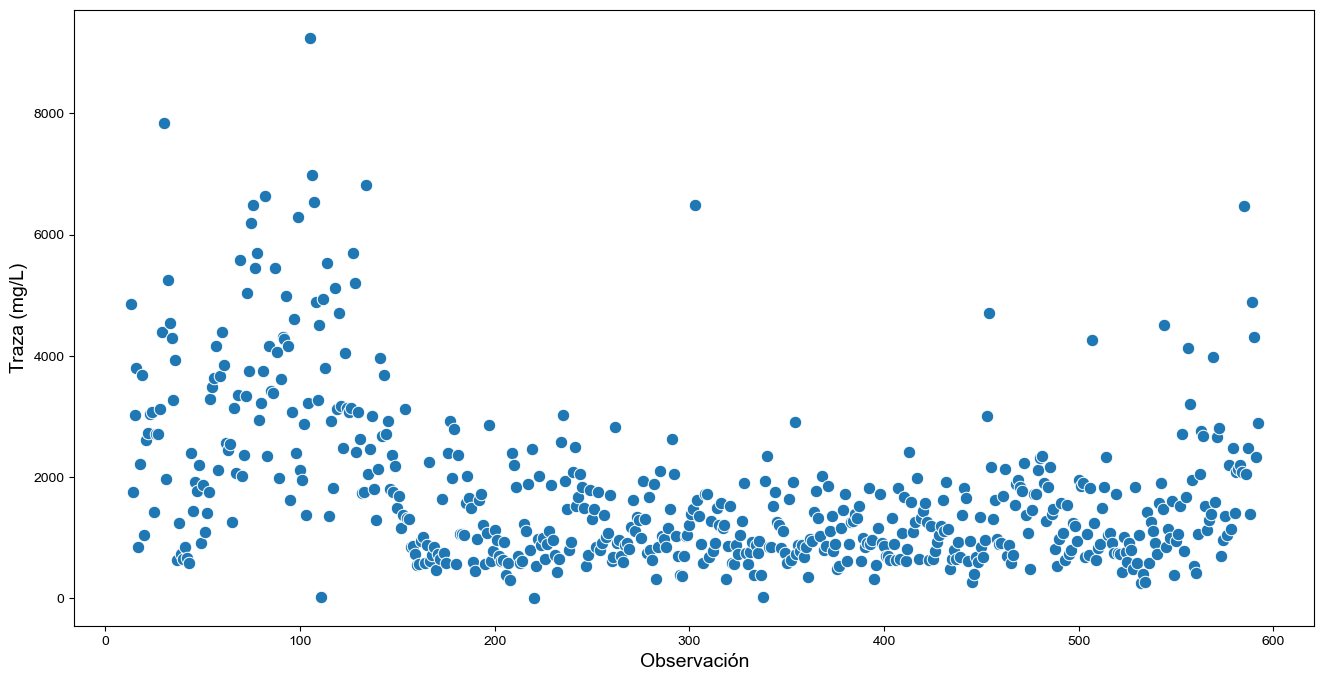

In [11]:
# Se grafica la variable objetivo
fig, ax = plt.subplots(figsize=(16,8)) # Se define tamaño de la figura y el los ejes
sns.set(style="darkgrid") # Se define el estilo del fondo
sns.set_context("talk") # Se define el estilo del contexto
ax = sns.scatterplot(x=df_raw.index, y=canal, data=df_raw) # Se configuran los parametros del grafico de dispersion
ax.set_ylabel(canal, fontsize=14) # Se define el titulo del eje y
ax.set_xlabel('Observación', fontsize=14) # Se define el titulo del eje X
plt.show() # Despliegue de grafica 

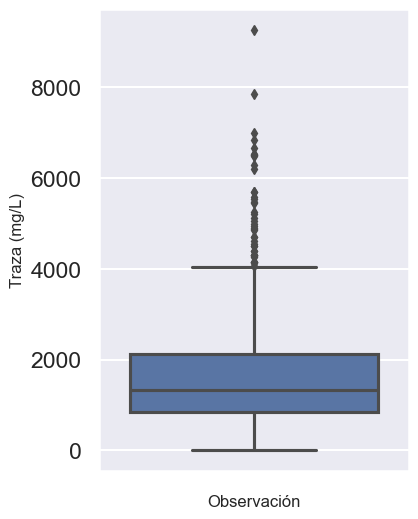

In [12]:
# Se grafican los valores atipicos de la variable objetivo
fig, ax = plt.subplots(figsize=(4,6)) # Se define tamaño de la figura y el los ejes
sns.set(style="darkgrid") # Se define el estilo del fondo
sns.set_context("talk") # Se define el estilo del contexto
ax = sns.boxplot(data=df_raw, y=canal) # Se configuran los parametros del grafico de cajas y bigotes
ax.set_ylabel(canal, fontsize=12) # Se define el titulo del eje y
ax.set_xlabel('Observación', fontsize=12) # Se define el titulo del eje X
plt.show() # Despliegue de grafica 

In [13]:
# Revision y cuantificacion de valores atipicos del conjunto de datos
quartiles= df_raw[canal].quantile([0.25,0.5,0.75]).values  # Se generan los 3 cuartiles de referencia 25%, 50% y 75%
q1 = quartiles[0] # Se asigna el 25% al cuartil 1
q2 = quartiles[1] # Se asigna el 50% al cuartil 2
q3 = quartiles[2] # Se asigna el 75% al cuartil 3
rango_inter = q3 - q1 # Se calcula el rango intercuartilico 75% - 25% 
limite_sup = q3 + 1.5*rango_inter # Se calcula el limite superior para valores atipicos
limite_inf = q1 - 1.5*rango_inter # Se calcula el limite inferior para valores atipicos
print(f" Limite superior: {limite_sup}, Limite inferior: {limite_inf}")

 Limite superior: 4061.5, Limite inferior: -1094.5


### Analisis del conjunto de datos Original

**Se evaluan las metricas Con Dia de Zafra.**

Se realiza el analisis, utilizando el conjunto de datos completo.

In [14]:
df_imp = df_raw.copy() # Se hace una copia del conjunto de datos
# Imputación de Medias por Día para Valores faltantes o con Error
df_imp = funciones.imputacion_media_dia(df_imp, False)  # Se llama a la funcion de imputación de valores, y se configura para que no tome en cuenta el dia de zafra


# Creación de Nuevas Features 
# Evaluar la creación de nuevas variables

df_imp

,Dia Zafra,Traza (mg/L),FT553705 Flujo agua asepsia Patio T-A (Gpm) AVG,FT553705 Flujo agua asepsia Patio T-A (Gpm) STD,FT553707 Flujo agua asepsia Molinos T-A (Gpm) AVG,FT553707 Flujo agua asepsia Molinos T-A (Gpm) STD,FT553706 Flujo agua asepsia Molinos T-B (Gpm) AVG,FT553706 Flujo agua asepsia Molinos T-B (Gpm) STD,FT553704 Flujo Agua de Asepsia a Patio T-B (Gpm) AVG,FT553704 Flujo Agua de Asepsia a Patio T-B (Gpm) STD,...,LT580704 Nivel Vaso E1 (%) AVG,LT580704 Nivel Vaso E1 (%) STD,LT580604 Nivel Vaso E2 (%) AVG,LT580604 Nivel Vaso E2 (%) STD,LT581704 Nivel Vaso E3 (%) AVG,LT581704 Nivel Vaso E3 (%) STD,LT581603 Nivel Vaso E4 (%) AVG,LT581603 Nivel Vaso E4 (%) STD,CT55101 Conductividad Canal Molinos (uS) AVG,CT55101 Conductividad Canal Molinos (uS) STD
13,2.0,4856.0,0.0,0.0,0.00,0.00,7.32,23.45,0.03,0.10,...,21.54,10.60,61.21,0.07,33.91,2.58,25.54,9.44,259.11,30.04
14,2.0,1752.0,0.0,0.0,0.00,0.00,7.35,23.52,0.03,0.09,...,10.16,4.78,0.02,0.11,0.30,0.08,1.68,2.83,477.69,12.79
15,2.0,3016.0,0.0,0.0,0.00,0.00,7.18,23.11,0.01,0.06,...,14.88,11.06,0.00,0.00,0.31,0.09,10.72,10.81,570.67,49.60
16,2.0,3792.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.03,...,55.81,14.39,0.00,0.00,33.73,10.26,45.69,4.58,585.98,17.83
17,2.0,839.0,0.0,0.0,0.00,0.00,6.98,22.40,0.01,0.05,...,30.79,18.32,0.00,0.00,33.02,2.32,47.54,5.49,515.89,65.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,99.0,1389.0,0.0,0.0,22.03,48.75,9.05,22.95,0.00,0.00,...,66.25,12.62,45.49,4.45,62.09,10.31,59.56,11.00,366.49,38.71
589,99.0,4881.0,0.0,0.0,17.11,41.60,4.27,9.39,0.00,0.00,...,2.19,0.05,21.84,3.60,0.00,0.01,4.85,2.26,110.01,79.88
590,99.0,4305.0,0.0,0.0,20.50,49.41,6.95,19.95,0.00,0.00,...,15.29,7.96,43.78,2.68,39.43,6.43,100.00,0.00,703.05,246.15
591,99.0,2328.0,0.0,0.0,18.32,45.35,8.86,23.91,0.00,0.00,...,58.42,18.32,44.55,0.80,49.72,4.58,97.87,0.51,91.80,9.74


In [15]:
df_imp.describe()  # Estadisticas Descriptivas del conjunto de datos

,Dia Zafra,Traza (mg/L),FT553705 Flujo agua asepsia Patio T-A (Gpm) AVG,FT553705 Flujo agua asepsia Patio T-A (Gpm) STD,FT553707 Flujo agua asepsia Molinos T-A (Gpm) AVG,FT553707 Flujo agua asepsia Molinos T-A (Gpm) STD,FT553706 Flujo agua asepsia Molinos T-B (Gpm) AVG,FT553706 Flujo agua asepsia Molinos T-B (Gpm) STD,FT553704 Flujo Agua de Asepsia a Patio T-B (Gpm) AVG,FT553704 Flujo Agua de Asepsia a Patio T-B (Gpm) STD,...,LT580704 Nivel Vaso E1 (%) AVG,LT580704 Nivel Vaso E1 (%) STD,LT580604 Nivel Vaso E2 (%) AVG,LT580604 Nivel Vaso E2 (%) STD,LT581704 Nivel Vaso E3 (%) AVG,LT581704 Nivel Vaso E3 (%) STD,LT581603 Nivel Vaso E4 (%) AVG,LT581603 Nivel Vaso E4 (%) STD,CT55101 Conductividad Canal Molinos (uS) AVG,CT55101 Conductividad Canal Molinos (uS) STD
count,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,...,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000
mean,50.944828,1743.000000,3.265759,0.509034,19.057259,42.793759,6.757741,14.969483,3.289345,2.224241,...,36.951638,9.038534,38.928103,5.473276,36.584879,5.755828,40.277759,5.808879,520.292276,153.020155
std,28.004510,1335.922095,9.904406,1.546852,17.558376,23.716545,12.281985,19.528351,22.748510,13.950249,...,24.253292,7.585570,21.352604,6.155641,20.805873,5.912543,19.982966,6.128813,762.345135,394.252149
min,2.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.490000,0.490000
25%,27.000000,839.000000,0.000000,0.000000,10.415000,33.455000,0.000000,0.000000,0.000000,0.000000,...,19.155000,2.635000,27.317500,1.135000,25.752500,1.137500,34.870000,1.467500,75.750000,13.530000
50%,51.000000,1327.000000,0.000000,0.000000,16.990000,51.340000,0.405000,2.115000,0.000000,0.020000,...,36.700000,7.705000,40.285000,3.950000,38.650000,3.560000,44.685000,4.075000,332.945000,39.335000
75%,75.000000,2128.000000,0.000000,0.000000,26.250000,58.582500,13.042500,35.832500,0.000000,0.040000,...,51.550000,13.950000,53.122500,7.460000,49.447500,8.875000,49.142500,8.307500,628.357500,131.267500
max,99.000000,9249.000000,48.720000,8.390000,176.630000,97.850000,154.330000,63.680000,263.830000,144.970000,...,100.000000,42.880000,98.700000,47.660000,89.580000,27.870000,100.000000,43.200000,7283.370000,3660.870000


### Tratamiento de Outliers y Distribución de Frecuencias de Valores de Trazas
Limpieza de valores extremos si fuera necesario.

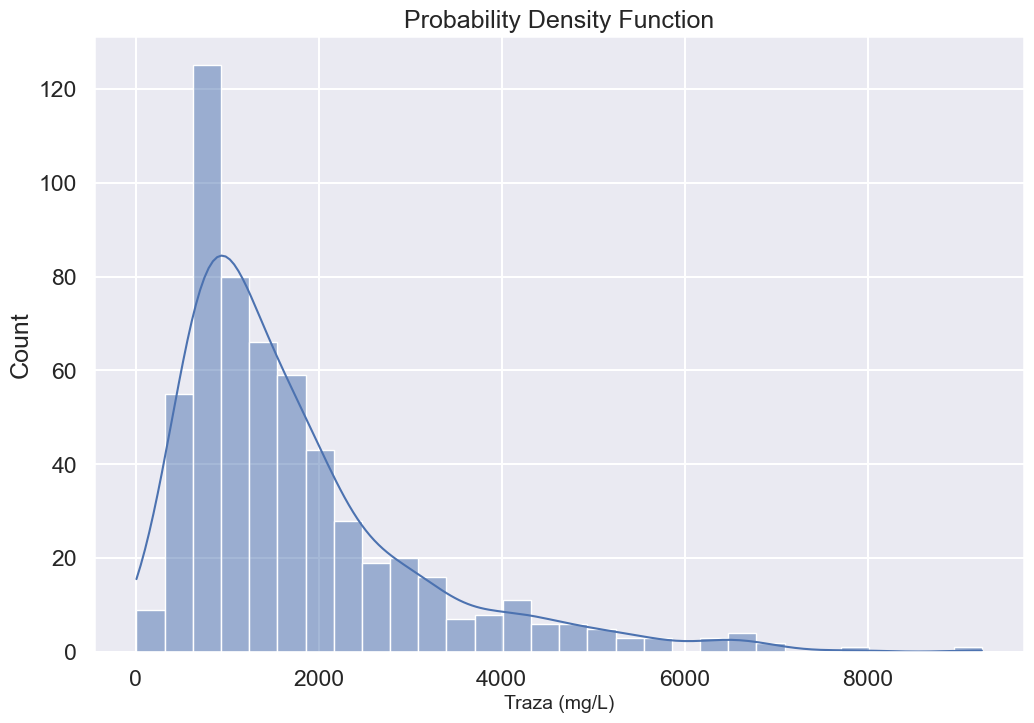

 Estadísticas de Conductividad: 


count     580.000000
mean     1743.000000
std      1335.922095
min         8.000000
25%       839.000000
50%      1327.000000
75%      2128.000000
max      9249.000000
Name: Traza (mg/L), dtype: float64

In [16]:
df = funciones.outliers(df_imp,canal,0) # Se grafica el histograma y se eliminan valores atipicos en caso necesario

### Determinación de Umbral Óptimo

Se aplica una **binarización** a la variable de traza. La binarización consiste en *transformar* la variable continua de traza a una variable binaria de *presencia* o *no presencia* de traza. Para la elaboración de un modelo operativo en la práctica es más útil definir un límite superior para esta variable.

La binarización se implementa de forma que: Una **alta traza de azúcar es una clase POSITIVA** y una **baja traza de azúcar es una clase NEGATIVA**.

Adicionalmente, debido a la distribución *sesgada* de la variable de trazas, es posible que una mala selección del umbral produzca un imbalance en el conjunto de entrenamiento y por lo tanto, métricas de detección del algoritmo que no son óptimas.

#### K-Means Clustering
Para poder distinguir entre clases, se ejecuta un algoritmo de clustering no-supervisado, con el propósito de encontrar **"regiones de operación"** en los datos, y luego verificar si estas regiones tienen en común algún rango de valores de trazas.

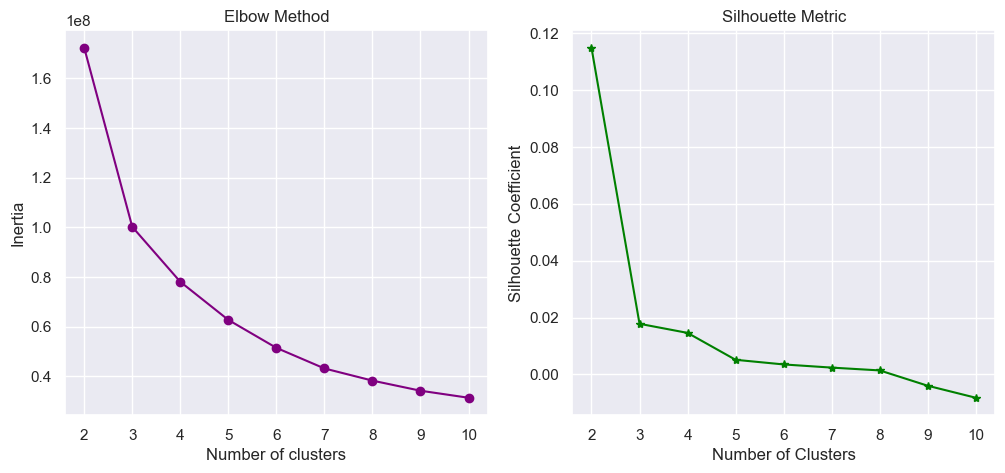

In [17]:
funciones.exploracion_clusters(df,canal) # Se revisan las metricas para poder realizar agrupaciones en el conjunto de datos 

Puede observarse que **las métricas de cohesión son más altas para 3 agrupaciones**. Se forman los 3 grupos utilizando el algoritmo K-Means, con n=3. Luego, se grafica la serie de tiempo de la traza durante la zafra y se colorean las regiones encontradas.

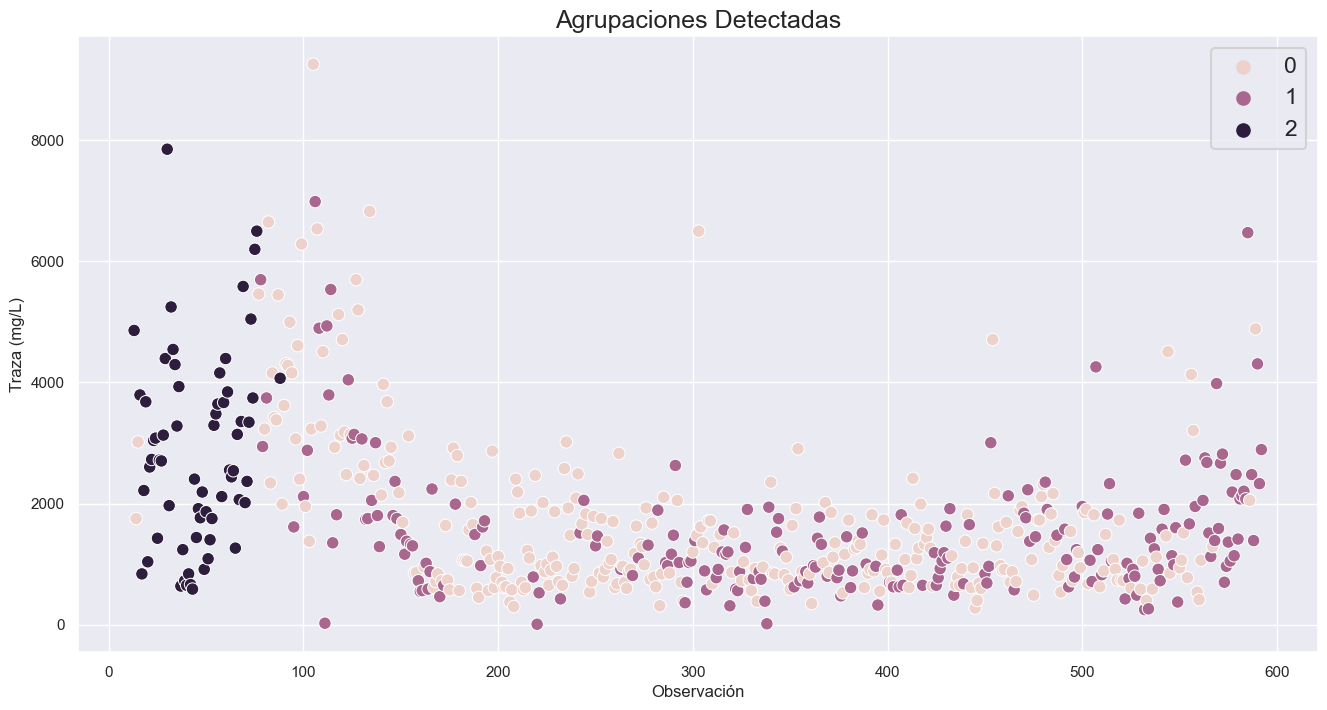

 Medias por Agrupación: 


,Dia Zafra,Traza (mg/L),FT553705 Flujo agua asepsia Patio T-A (Gpm) AVG,FT553705 Flujo agua asepsia Patio T-A (Gpm) STD,FT553707 Flujo agua asepsia Molinos T-A (Gpm) AVG,FT553707 Flujo agua asepsia Molinos T-A (Gpm) STD,FT553706 Flujo agua asepsia Molinos T-B (Gpm) AVG,FT553706 Flujo agua asepsia Molinos T-B (Gpm) STD,FT553704 Flujo Agua de Asepsia a Patio T-B (Gpm) AVG,FT553704 Flujo Agua de Asepsia a Patio T-B (Gpm) STD,LT55M101 Nivel Chute Molino No. 1 TA (%) AVG,LT55M101 Nivel Chute Molino No. 1 TA (%) STD,LT55M201 Nivel Chute Molino No. 2 TA (%) AVG,LT55M201 Nivel Chute Molino No. 2 TA (%) STD,LT55M301 Nivel Chute Molino No. 3 TA (%) AVG,LT55M301 Nivel Chute Molino No. 3 TA (%) STD,LT55M401 Nivel Chute Molino No. 4 TA (%) AVG,LT55M401 Nivel Chute Molino No. 4 TA (%) STD,LT55M501 Nivel Chute Molino No. 5 TA (%) AVG,LT55M501 Nivel Chute Molino No. 5 TA (%) STD,LT55M601 Nivel Chute Molino No. 6 TA (%) AVG,LT55M601 Nivel Chute Molino No. 6 TA (%) STD,LT55N101 Nivel Chute Molino No. 1 TB (%) AVG,LT55N101 Nivel Chute Molino No. 1 TB (%) STD,LT55N201 Nivel Chute Molino No. 2 TB (%) AVG,LT55N201 Nivel Chute Molino No. 2 TB (%) STD,LT55N301 Nivel Chute Molino No. 3 TB (%) AVG,LT55N301 Nivel Chute Molino No. 3 TB (%) STD,LT55N401 Nivel Chute Molino No. 4 TB (%) AVG,LT55N401 Nivel Chute Molino No. 4 TB (%) STD,LT55N501 Nivel Chute Molino No. 5 TB (%) AVG,LT55N501 Nivel Chute Molino No. 5 TB (%) STD,LT55N601 Nivel Chute Molino No. 6 TB (%) AVG,LT55N601 Nivel Chute Molino No. 6 TB (%) STD,LT555803 Nivel Tanque Jugo Mezclado TB (%) AVG,LT555803 Nivel Tanque Jugo Mezclado TB (%) STD,LT555801 Nivel Tanque Jugo Filtrado TA (%) AVG,LT555801 Nivel Tanque Jugo Filtrado TA (%) STD,LT555804 Nivel Tanque Jugo Mezclado TB (%) AVG,LT555804 Nivel Tanque Jugo Mezclado TB (%) STD,LT555802 Nivel Tanque Jugo Filtrado TB (%) AVG,LT555802 Nivel Tanque Jugo Filtrado TB (%) STD,LT58A101 Nivel Vaso A1 (%) AVG,LT58A101 Nivel Vaso A1 (%) STD,LT58A201 Nivel Vaso A2 (%) AVG,LT58A201 Nivel Vaso A2 (%) STD,LT58A301 Nivel Vaso A3 (%) AVG,LT58A301 Nivel Vaso A3 (%) STD,LT58A404 Nivel Vaso A4 (%) AVG,LT58A404 Nivel Vaso A4 (%) STD,LT584001 Nivel Vaso A5 (%) AVG,LT584001 Nivel Vaso A5 (%) STD,LT584104 Nivel Vaso A6 (%) AVG,LT584104 Nivel Vaso A6 (%) STD,LT584204 Nivel Vaso A7 (%) AVG,LT584204 Nivel Vaso A7 (%) STD,LT584301 Nivel Vaso A8 (%) AVG,LT584301 Nivel Vaso A8 (%) STD,LT584401 Nivel Vaso A9 (%) AVG,LT584401 Nivel Vaso A9 (%) STD,LT58P604 Nivel Vaso B1 (%) AVG,LT58P604 Nivel Vaso B1 (%) STD,LT585604 Nivel Vaso B2 (%) AVG,LT585604 Nivel Vaso B2 (%) STD,LT585501 Nivel Vaso B3 (%) AVG,LT585501 Nivel Vaso B3 (%) STD,LT585401 Nivel Vaso B4 (%) AVG,LT585401 Nivel Vaso B4 (%) STD,LT585304 Nivel Vaso B5 (%) AVG,LT585304 Nivel Vaso B5 (%) STD,LT585204 Nivel Vaso B6 (%) AVG,LT585204 Nivel Vaso B6 (%) STD,LT58P704 Nivel Vaso B7 (%) AVG,LT58P704 Nivel Vaso B7 (%) STD,LT58D804 Nivel Vaso B8 (%) AVG,LT58D804 Nivel Vaso B8 (%) STD,LT58D201 Nivel Vaso C1 (%) AVG,LT58D201 Nivel Vaso C1 (%) STD,LT585101 Nivel Vaso C2 (%) AVG,LT585101 Nivel Vaso C2 (%) STD,LT58D704 Nivel Vaso C3 (%) AVG,LT58D704 Nivel Vaso C3 (%) STD,LT58D603 Nivel Vaso C4 (%) AVG,LT58D603 Nivel Vaso C4 (%) STD,LT584903 Nivel Vaso C5 (%) AVG,LT584903 Nivel Vaso C5 (%) STD,LT584803 Nivel Vaso D1 (%) AVG,LT584803 Nivel Vaso D1 (%) STD,LT584503 Nivel Vaso D2 (%) AVG,LT584503 Nivel Vaso D2 (%) STD,LT584604 Nivel Vaso D3 (%) AVG,LT584604 Nivel Vaso D3 (%) STD,LT584704 Nivel Vaso D4 (%) AVG,LT584704 Nivel Vaso D4 (%) STD,LT585004 Nivel Vaso D5 (%) AVG,LT585004 Nivel Vaso D5 (%) STD,LT580704 Nivel Vaso E1 (%) AVG,LT580704 Nivel Vaso E1 (%) STD,LT580604 Nivel Vaso E2 (%) AVG,LT580604 Nivel Vaso E2 (%) STD,LT581704 Nivel Vaso E3 (%) AVG,LT581704 Nivel Vaso E3 (%) STD,LT581603 Nivel Vaso E4 (%) AVG,LT581603 Nivel Vaso E4 (%) STD,CT55101 Conductividad Canal Molinos (uS) AVG,CT55101 Conductividad Canal Molinos (uS) STD
group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

 Desviaciones Estándar por Agrupación: 


,Dia Zafra,Traza (mg/L),FT553705 Flujo agua asepsia Patio T-A (Gpm) AVG,FT553705 Flujo agua asepsia Patio T-A (Gpm) STD,FT553707 Flujo agua asepsia Molinos T-A (Gpm) AVG,FT553707 Flujo agua asepsia Molinos T-A (Gpm) STD,FT553706 Flujo agua asepsia Molinos T-B (Gpm) AVG,FT553706 Flujo agua asepsia Molinos T-B (Gpm) STD,FT553704 Flujo Agua de Asepsia a Patio T-B (Gpm) AVG,FT553704 Flujo Agua de Asepsia a Patio T-B (Gpm) STD,LT55M101 Nivel Chute Molino No. 1 TA (%) AVG,LT55M101 Nivel Chute Molino No. 1 TA (%) STD,LT55M201 Nivel Chute Molino No. 2 TA (%) AVG,LT55M201 Nivel Chute Molino No. 2 TA (%) STD,LT55M301 Nivel Chute Molino No. 3 TA (%) AVG,LT55M301 Nivel Chute Molino No. 3 TA (%) STD,LT55M401 Nivel Chute Molino No. 4 TA (%) AVG,LT55M401 Nivel Chute Molino No. 4 TA (%) STD,LT55M501 Nivel Chute Molino No. 5 TA (%) AVG,LT55M501 Nivel Chute Molino No. 5 TA (%) STD,LT55M601 Nivel Chute Molino No. 6 TA (%) AVG,LT55M601 Nivel Chute Molino No. 6 TA (%) STD,LT55N101 Nivel Chute Molino No. 1 TB (%) AVG,LT55N101 Nivel Chute Molino No. 1 TB (%) STD,LT55N201 Nivel Chute Molino No. 2 TB (%) AVG,LT55N201 Nivel Chute Molino No. 2 TB (%) STD,LT55N301 Nivel Chute Molino No. 3 TB (%) AVG,LT55N301 Nivel Chute Molino No. 3 TB (%) STD,LT55N401 Nivel Chute Molino No. 4 TB (%) AVG,LT55N401 Nivel Chute Molino No. 4 TB (%) STD,LT55N501 Nivel Chute Molino No. 5 TB (%) AVG,LT55N501 Nivel Chute Molino No. 5 TB (%) STD,LT55N601 Nivel Chute Molino No. 6 TB (%) AVG,LT55N601 Nivel Chute Molino No. 6 TB (%) STD,LT555803 Nivel Tanque Jugo Mezclado TB (%) AVG,LT555803 Nivel Tanque Jugo Mezclado TB (%) STD,LT555801 Nivel Tanque Jugo Filtrado TA (%) AVG,LT555801 Nivel Tanque Jugo Filtrado TA (%) STD,LT555804 Nivel Tanque Jugo Mezclado TB (%) AVG,LT555804 Nivel Tanque Jugo Mezclado TB (%) STD,LT555802 Nivel Tanque Jugo Filtrado TB (%) AVG,LT555802 Nivel Tanque Jugo Filtrado TB (%) STD,LT58A101 Nivel Vaso A1 (%) AVG,LT58A101 Nivel Vaso A1 (%) STD,LT58A201 Nivel Vaso A2 (%) AVG,LT58A201 Nivel Vaso A2 (%) STD,LT58A301 Nivel Vaso A3 (%) AVG,LT58A301 Nivel Vaso A3 (%) STD,LT58A404 Nivel Vaso A4 (%) AVG,LT58A404 Nivel Vaso A4 (%) STD,LT584001 Nivel Vaso A5 (%) AVG,LT584001 Nivel Vaso A5 (%) STD,LT584104 Nivel Vaso A6 (%) AVG,LT584104 Nivel Vaso A6 (%) STD,LT584204 Nivel Vaso A7 (%) AVG,LT584204 Nivel Vaso A7 (%) STD,LT584301 Nivel Vaso A8 (%) AVG,LT584301 Nivel Vaso A8 (%) STD,LT584401 Nivel Vaso A9 (%) AVG,LT584401 Nivel Vaso A9 (%) STD,LT58P604 Nivel Vaso B1 (%) AVG,LT58P604 Nivel Vaso B1 (%) STD,LT585604 Nivel Vaso B2 (%) AVG,LT585604 Nivel Vaso B2 (%) STD,LT585501 Nivel Vaso B3 (%) AVG,LT585501 Nivel Vaso B3 (%) STD,LT585401 Nivel Vaso B4 (%) AVG,LT585401 Nivel Vaso B4 (%) STD,LT585304 Nivel Vaso B5 (%) AVG,LT585304 Nivel Vaso B5 (%) STD,LT585204 Nivel Vaso B6 (%) AVG,LT585204 Nivel Vaso B6 (%) STD,LT58P704 Nivel Vaso B7 (%) AVG,LT58P704 Nivel Vaso B7 (%) STD,LT58D804 Nivel Vaso B8 (%) AVG,LT58D804 Nivel Vaso B8 (%) STD,LT58D201 Nivel Vaso C1 (%) AVG,LT58D201 Nivel Vaso C1 (%) STD,LT585101 Nivel Vaso C2 (%) AVG,LT585101 Nivel Vaso C2 (%) STD,LT58D704 Nivel Vaso C3 (%) AVG,LT58D704 Nivel Vaso C3 (%) STD,LT58D603 Nivel Vaso C4 (%) AVG,LT58D603 Nivel Vaso C4 (%) STD,LT584903 Nivel Vaso C5 (%) AVG,LT584903 Nivel Vaso C5 (%) STD,LT584803 Nivel Vaso D1 (%) AVG,LT584803 Nivel Vaso D1 (%) STD,LT584503 Nivel Vaso D2 (%) AVG,LT584503 Nivel Vaso D2 (%) STD,LT584604 Nivel Vaso D3 (%) AVG,LT584604 Nivel Vaso D3 (%) STD,LT584704 Nivel Vaso D4 (%) AVG,LT584704 Nivel Vaso D4 (%) STD,LT585004 Nivel Vaso D5 (%) AVG,LT585004 Nivel Vaso D5 (%) STD,LT580704 Nivel Vaso E1 (%) AVG,LT580704 Nivel Vaso E1 (%) STD,LT580604 Nivel Vaso E2 (%) AVG,LT580604 Nivel Vaso E2 (%) STD,LT581704 Nivel Vaso E3 (%) AVG,LT581704 Nivel Vaso E3 (%) STD,LT581603 Nivel Vaso E4 (%) AVG,LT581603 Nivel Vaso E4 (%) STD,CT55101 Conductividad Canal Molinos (uS) AVG,CT55101 Conductividad Canal Molinos (uS) STD
group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [18]:
funciones.clustering(df,canal,3) # Se configura para generar la cantidad de grupos deseada en el conjunto de datos

Puede observarse que las agrupaciones 0 y 1 comparten tendencias de traza bajas similares con medias debajo 1700 mg/L. La agrupación 2 sin embargo tiene una media de por arriba de 2800 mg/L.

Para explorar este umbral de trazas, se implementa un algoritmo que explora *distintos umbrales de trazas* y grafica las métricas de entrenamiento para cada selección:

- **Precision:** Habilidad del Clasificador de minimizar Falsos Positivos.
- **Accuracy:** Habilidad del Clasificador de Detectar Verdaderos Positivos y Verdaderos Negativos.
- **Recall:** Habilidad del Clasificador de Detectar Verdaderos Positivos.
- **F1:** Media Ponderada de la Precision y el Recall.
- **AUC:** Habilidad General del Clasificador para Distinguir entre las clases Positiva y Negativa.
- **Overall:** Media Aritmética de todas las métricas anteriores.


De esta forma, se obtiene una **propuesta de umbral óptima**.

,Precision,Accuracy,F1,Recall,AUC (%),Overall,Clase Positiva (%)
Umbral Conductividad,,,,,,,
400.0,0.953749,0.942529,0.970414,0.964706,0.339706,0.834221,96.724138
500.0,0.895594,0.879310,0.935780,0.927273,0.352862,0.798164,95.172414
750.0,0.708105,0.741379,0.842105,0.882353,0.520511,0.738891,79.827586
1000.0,0.583409,0.597701,0.690265,0.757282,0.607138,0.647159,63.965517
1250.0,0.667432,0.655172,0.677419,0.759036,0.693367,0.690485,53.620690
1500.0,0.647059,0.643678,0.575342,0.591549,0.680706,0.627667,43.620690
1750.0,0.721746,0.724138,0.571429,0.561404,0.685860,0.652915,36.379310
2000.0,0.775962,0.781609,0.568182,0.543478,0.712466,0.676339,28.103448
2500.0,0.843455,0.821839,0.563380,0.645161,0.838033,0.742374,19.137931


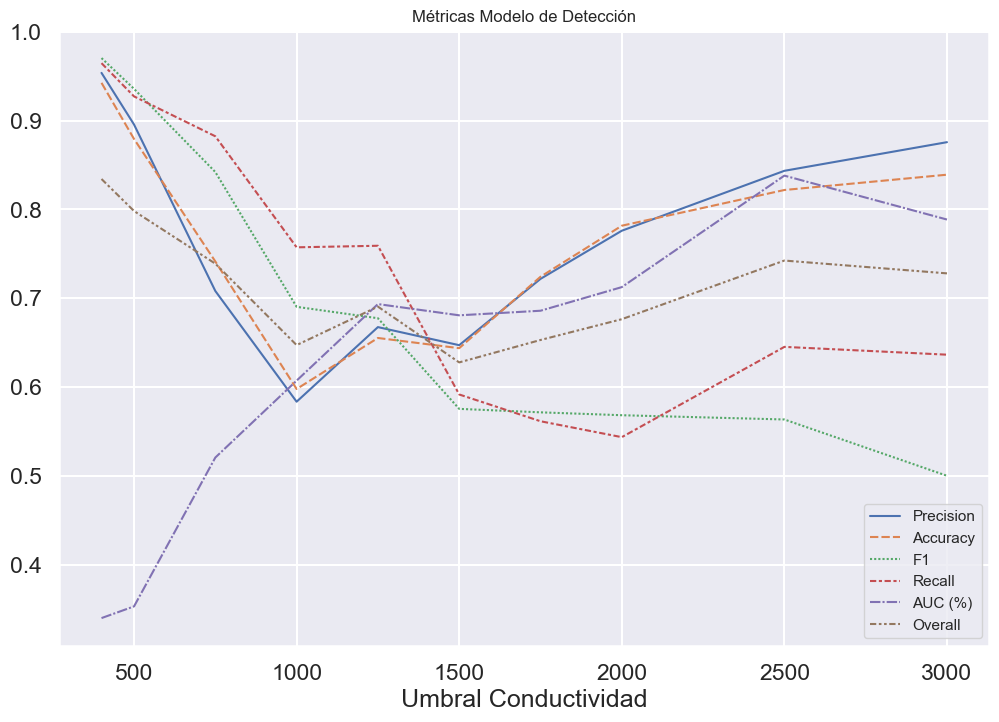

In [19]:
funciones.busqueda_umbral(df,canal,[400,500,750,1000,1250,1500,1750,2000,2500,3000]) # Se revisan las metricas para diferentes valores de umbral

#### Selección de Umbral
El criterio para seleccionar el umbral se propone sea el del **"cima"**. En este método se selecciona un umbral a partir del cual las métricas caen por debajo de un nivel "aceptable".

Por ejemplo, una conductividad de 1250 nos proporciona suficiente rango y además las métricas están arriba al 65%.


### Entrenamiento Modelo de Clasificación
Basado en los resultados anteriores, se selecciona un umbral y se entrena el modelo de detección.

In [20]:
# Umbral de Detección
umbral_final = 1250 # Se define el umbral de deteccion segun las metricas revisadas

# Binarización y construcción del Dataset de Entrenamiento y Validación
X = df.drop(canal, axis=1) # Se define el conjunto de datos de las variables independientes 
y = df[canal].apply(lambda x: 1 if x > umbral_final else 0) # Se define la variable dependiente 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123456) # Se genera el conjunto de datos de entrenamiento y prueba 

In [21]:
# Estandarización y Entrenamiento
scaler = StandardScaler()   # Se deine procedimiento de Escalado
X_train_scaled = scaler.fit_transform(X_train) # Se aplica el escalado al conjunto de datos de entrenamiento de las variables independientes   
X_test_scaled = scaler.transform(X_test) # Se aplica el escalado al conjunto de datos de prueba de las variables independientes
model = LogisticRegression() # Se define el algoritmo para el modelo
model.fit(X_train_scaled, y_train) # Se ajusta el modelo con el conjunto de datos de entrenamiento escalado de variables independientes y con la variable dependiente  
coefficients = model.coef_[0] # Se extraen los coeficientes del modelo

### Métricas Finales de Entrenamiento y Matriz de Confusión
Se muestran las métricas del modelo final y su desempeño para detectar Verdaderos Positivos, Verdaderos Negativos, Falsos Positivos y Falsos Negativos.

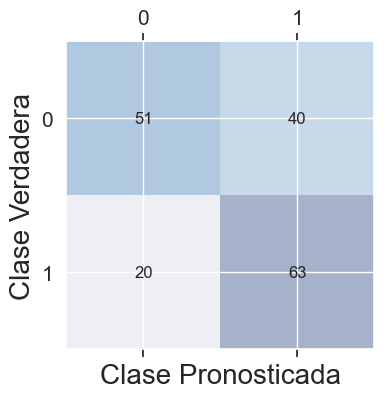

In [22]:
y_pred = model.predict(X_test_scaled) # Se evalua el modelo con el conjunto de datos de prueba escalado 
y_pred_prob = model.predict_proba(X_test_scaled) # Se evaluala la probabilidad de las predicciones realizadas por el modelo 

conf_mat = funciones.matriz_confusion(y_test,y_pred) # Se muestra la matriz de confusion

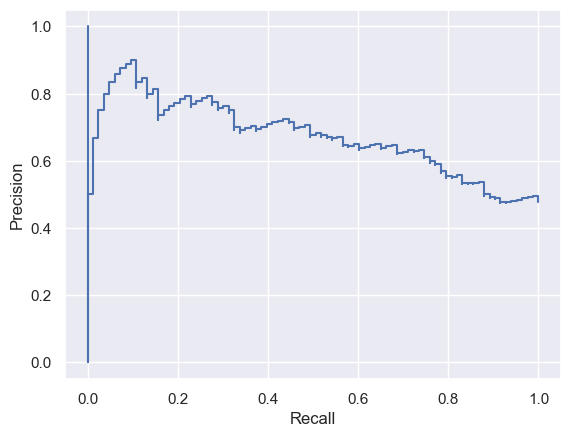

,Umbral Conductividad,Precision (%),Accuracy (%),F1 (%),Recall (%),AUC (%),Overall (%)
0,1250.0,66.743211,65.517241,67.741935,75.903614,69.336687,69.048538


In [23]:
funciones.metricas_finales(y_test,y_pred,y_pred_prob[:, 1],umbral_final) # Se muestran las metricas finales del modelo generado con el umbral definido 

### Factores de Importancia
Para la determinación de los factores de importancia se presentan dos perspectivas: Importancia por Magnitud del Factor e Importancia por Control del Factor.

#### Importancia por Magnitud del Factor
Esta importancia es el peso relativo que tiene este factor respecto a los demás factores, para contribuir positivamente o negativamente a la traza.
Si la contribución es positiva, a mayor magnitud del factor, mayor probabilidad de detectar la clase positiva (mayor probabilidad de alta traza).
Si la contribución es negativa, a mayor magnitud del factor, mayor probabilidad de detectar la clase negativa (menor probabilidad de alta traza).

#### Importancia por Control del Factor
Esta importancia se calcula a partir del efecto que tiene aleatorizar la variable (manteniendo todas las demás constantes) sobre la conductividad. Esto es especialmente importante para identificar **el efecto que tiene la precisión del control de la variable sobre la traza final**.

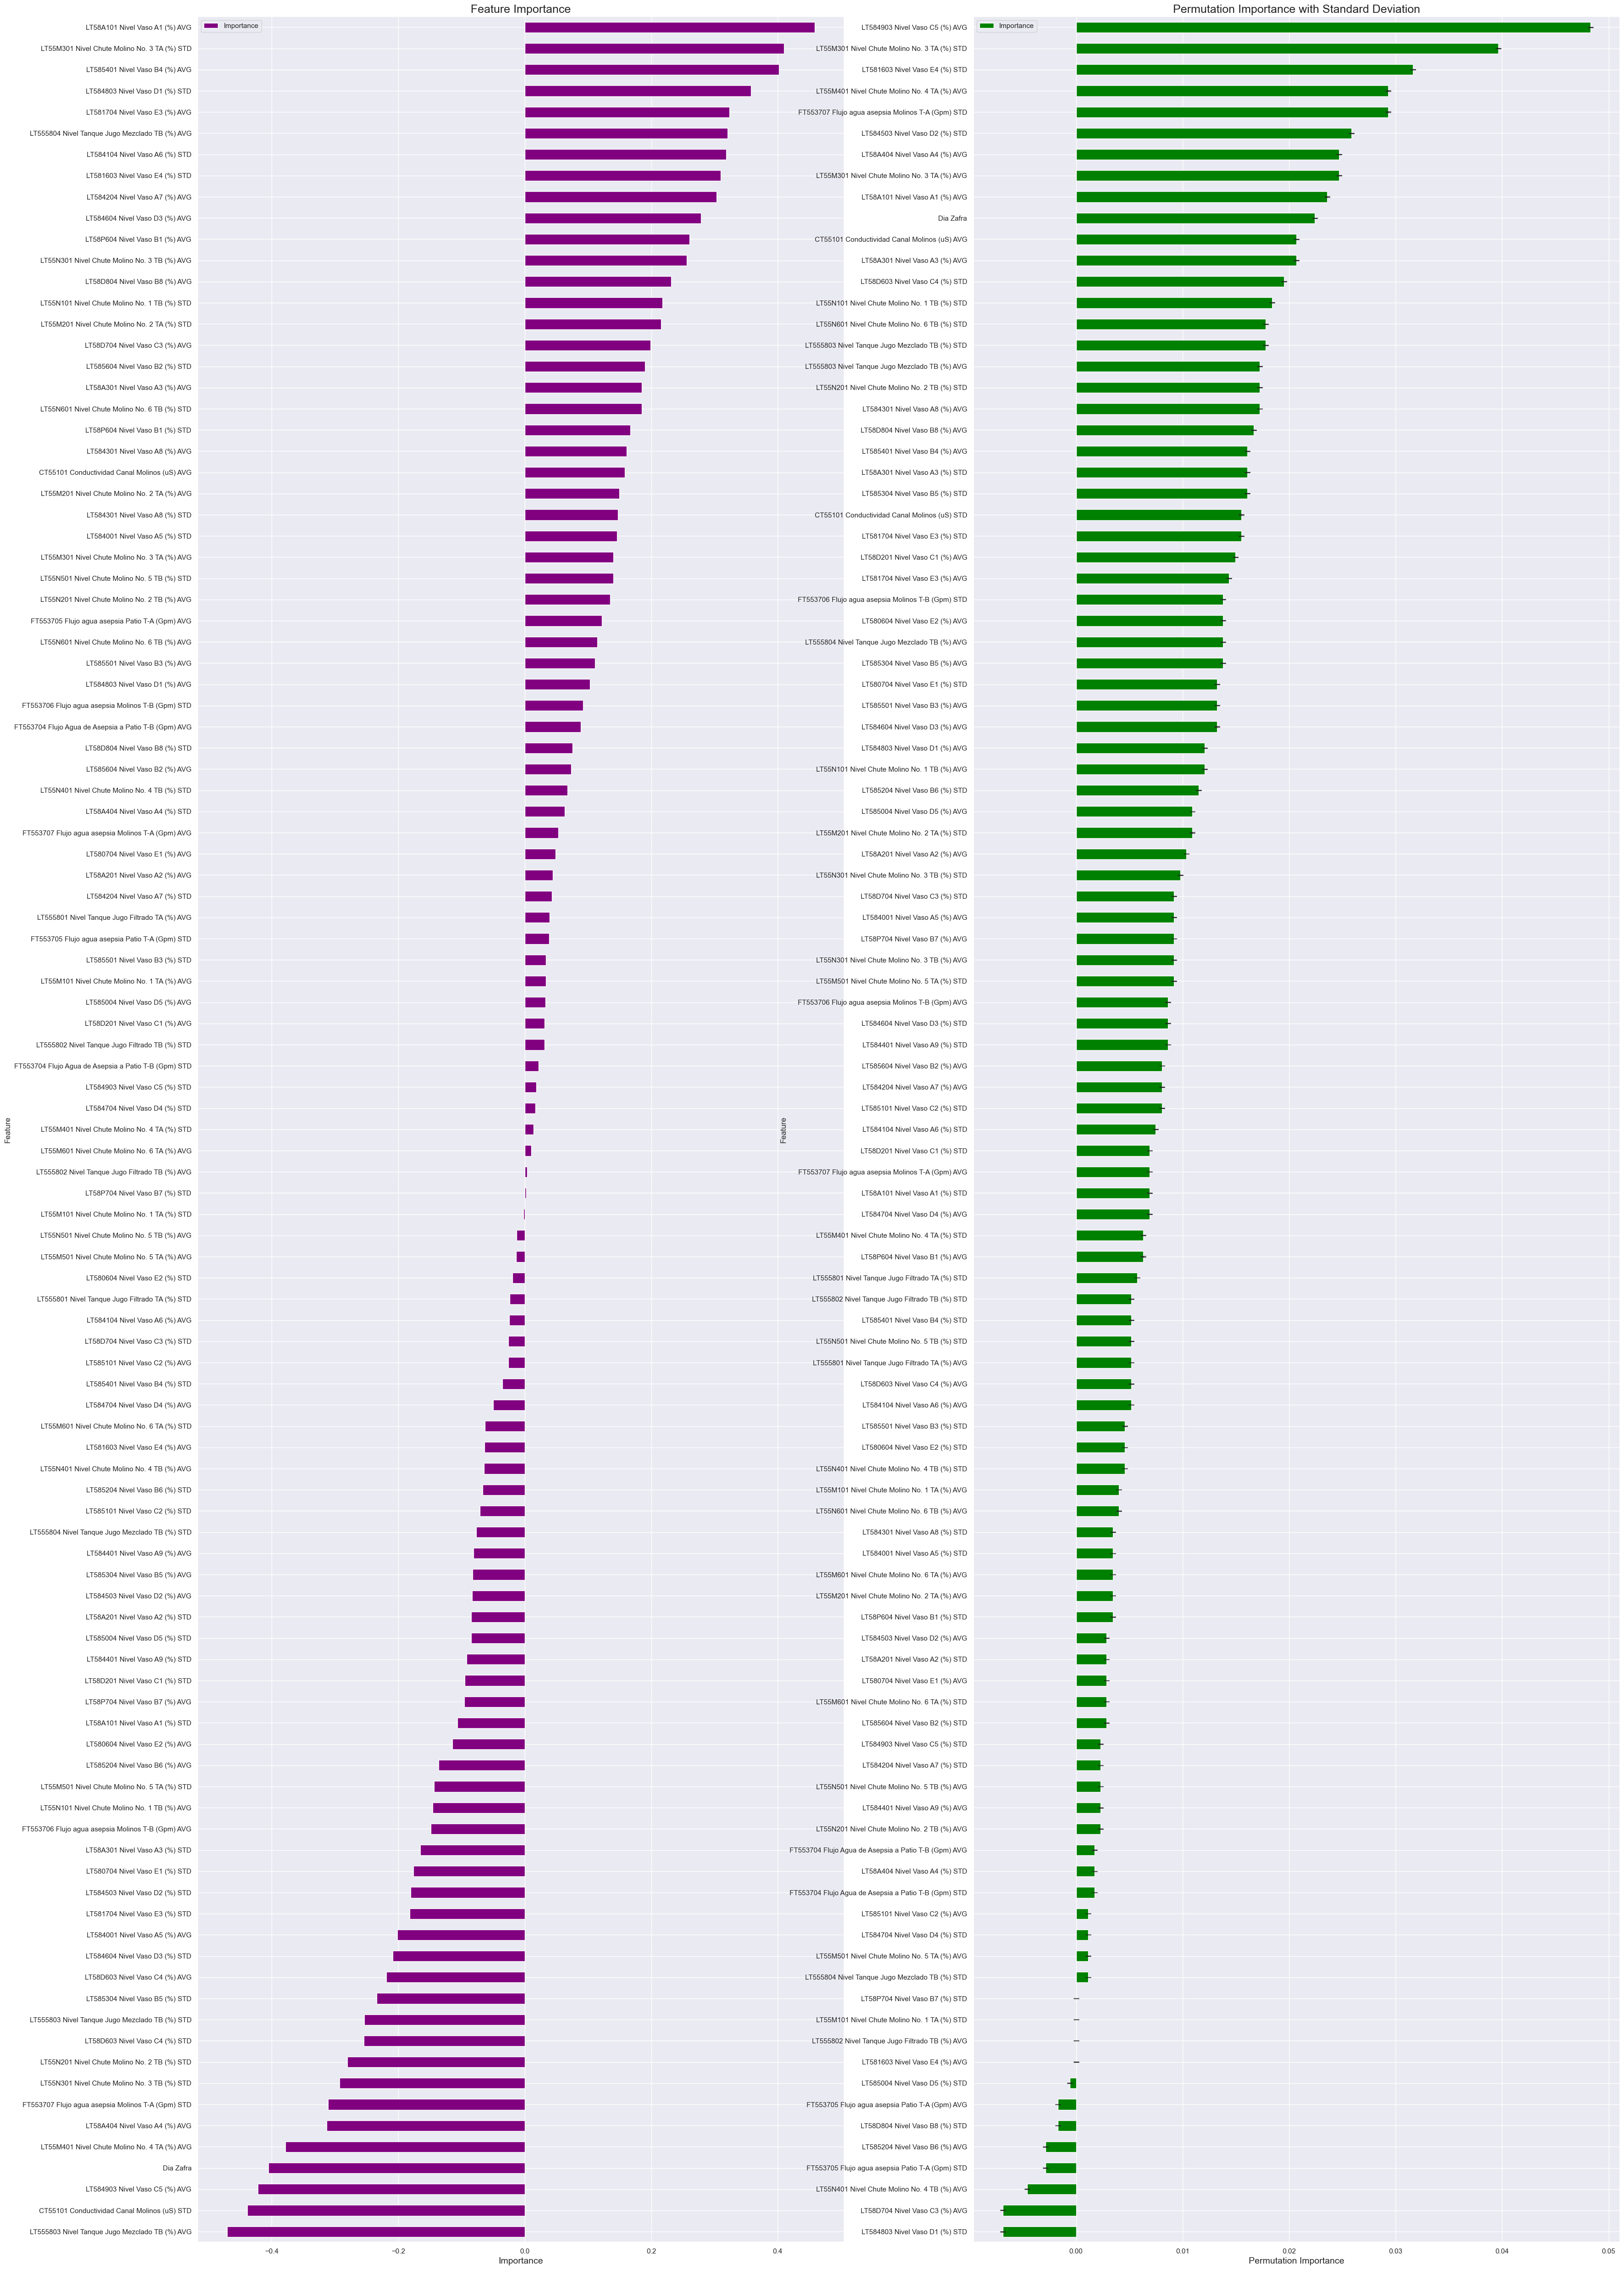

In [24]:
funciones.importancias_modelo(model,X,coefficients,X_test_scaled,y_test) # Se muestrasn los factores de importancia por Magnitud y Control 

### Probabilidad de Clase Positiva (Alta Magnitud de Traza)
El modelo permite conocer cómo cada factor impacta la probabilidad de obtener la **clase positiva** (*alta traza*). 

Para ello se presentan los **incrementos en probabilidad**: *Si el factor tiene un incremento unitario, cuánto aumenta la probabilidad de tener un alto valor de traza*.

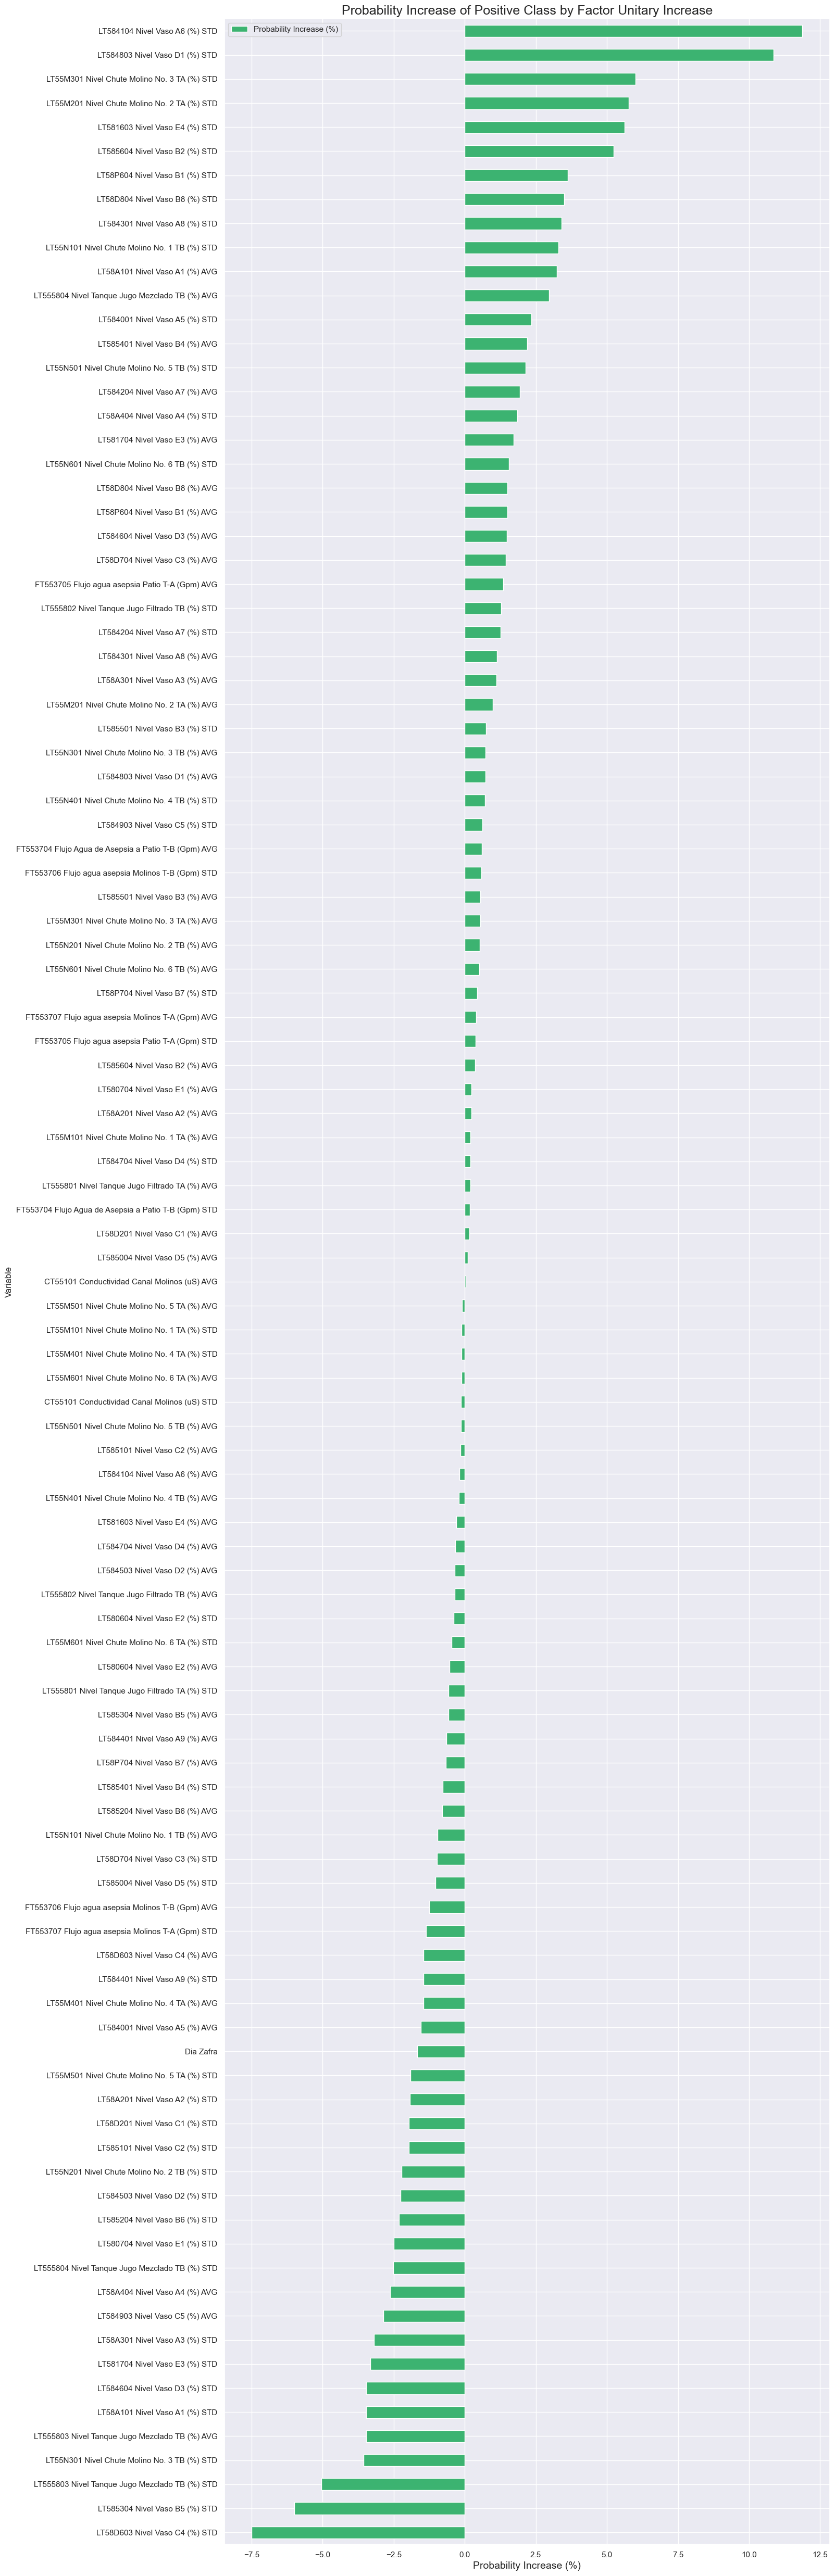

In [25]:
funciones.logprob(X,X_train,y_train) # Se muestran los factores de importancia para la Clase Positiva 

### Conclusiones:
Dados los factores de importancia identificados, las recomendaciones son las siguientes:
- Para los **factores con mayor importancia por magnitud** se recomienda controlar con un **SP menor** (si la importancia por magnitud es **positiva**) o con un **SP mayor** (si la importancia por magnitud es **negativa**) para *reducir la probabilidad de tener un valor alto de traza*.
- Para conocer *qué tanto incrementar o decrementar el SP del factor*, se verifica su contribución a la **Probabilidad de Clase Positiva**: Si la contribución es positiva, se recomienda reducir el SP. Si la contribución es negativa, se recomienda aumentar el SP. Ambas acciones **reducirán la probabilidad de ocurrencia de la clase positiva** (alta traza).
- Para los **factores con mayor importancia por control** se recomienda **reducir la varianza de la variable** (reducir su variación si es posible por medios manuales o ajustes de los lazos de control involucrados). En el caso de *importancias negativas*, significa que los algoritmos *no encontraron evidencia de que el control de esta variable importe para la estabilidad del valor de traza*.